In [43]:
from torch.distributions import Normal
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import gymnasium
import imageio
import random

In [44]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, action_dim)
        )
        self.log_std = nn.Parameter(torch.zeros(action_dim))

    def forward(self, state):
        mean = self.network(state)
        log_std = self.log_std.expand_as(mean)
        std = torch.exp(log_std)
        return Normal(mean, std)


class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, state):
        return self.network(state)

In [45]:
class PPO:
    def __init__(self, state_dim, action_dim):
        self.gamma = 0.99
        self.lam = 0.95
        self.num_epochs = 10
        self.minibatch_size = 64
        self.clip_eps = 0.2
        self.actor = Actor(state_dim, action_dim)
        self.critic = Critic(state_dim)
        self.learning_rate = 3e-4
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=self.learning_rate)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.learning_rate)

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        dist = self.actor(state)
        action = dist.sample().squeeze(0)
        log_prob = dist.log_prob(action).squeeze()
        return action.numpy(), log_prob

    def compute_rewards_to_go(self, rewards):
        rtg = []
        discounted_sum = 0
        for reward in reversed(rewards):
            discounted_sum = reward + self.gamma * discounted_sum
            rtg.insert(0, discounted_sum)
        return torch.tensor(rtg)

    def compute_advantages(self, states, rewards):
        values = self.critic(states).squeeze().detach()

        T = len(rewards)
        advantages = torch.zeros(T, dtype=torch.float32)
        gae = 0.0
        for t in reversed(range(T - 1)):
            td_error = rewards[t] + self.gamma * values[t + 1] - values[t]
            gae = td_error + self.gamma * self.lam * gae
            advantages[t] = gae

        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-10)
        return advantages

    def update(self, states, actions, log_probs_old, advantages, rewards_to_go):
        total_samples = states.size(0)

        for _ in range(self.num_epochs):
            perm = torch.randperm(total_samples)

            states_perm, actions_perm, log_probs_old_perm, advantages_perm, rewards_to_go_perm = \
                states[perm], actions[perm], log_probs_old[perm], advantages[perm], rewards_to_go[perm]

            # Process each minibatch
            for i in range(0, total_samples, self.minibatch_size):
                states_batch = states_perm[i:i + self.minibatch_size]
                actions_batch = actions_perm[i:i + self.minibatch_size]
                log_probs_old_batch = log_probs_old_perm[i:i + self.minibatch_size]
                advantages_batch = advantages_perm[i:i + self.minibatch_size]
                rewards_to_go_batch = rewards_to_go_perm[i:i + self.minibatch_size]

                # Recompute distribution for current policy
                dist = self.actor(states_batch)
                log_probs = dist.log_prob(actions_batch).squeeze()

                # Calculate the ratio of new to old probabilities
                ratios = torch.exp(log_probs - log_probs_old_batch.detach())

                # Clipping the ratio to stabilize training
                clipped_ratios = torch.clamp(ratios, 1 - self.clip_eps, 1 + self.clip_eps)

                # Calculate the clipped and unclipped objective
                unclipped_objective = ratios * advantages_batch
                clipped_objective = clipped_ratios * advantages_batch

                # Negative sign to run gradient ascent
                actor_loss = -torch.min(unclipped_objective, clipped_objective).mean()

                values = self.critic(states_batch).squeeze()

                # Critic loss
                critic_loss = nn.MSELoss()(values, rewards_to_go_batch)

                # Optimize the actor
                self.actor_optimizer.zero_grad()
                actor_loss.backward(retain_graph=True)
                self.actor_optimizer.step()

                # Optimize the critic
                self.critic_optimizer.zero_grad()
                critic_loss.backward()
                self.critic_optimizer.step()

In [11]:
env = gymnasium.make("InvertedPendulum-v5", render_mode="rgb_array")

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

rewards_over_seeds = []
num_episodes = 500

for seed in [1, 2, 3, 5, 8]:
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    # Reinitialize agent every seed
    agent = PPO(state_dim, action_dim)
    rewards_over_episodes = []

    for episode in range(1, num_episodes + 1):
        # Episode generation
        states, actions, rewards, log_probs = [], [], [], []

        state, _ = env.reset()
        done = False
        while not done:
            action, log_prob = agent.select_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)

            states.append(state)
            actions.append(action)
            rewards.append(reward)
            log_probs.append(log_prob)

            done = terminated or truncated
            state = next_state

        states, actions, rewards, log_probs = torch.FloatTensor(np.vstack(states)), torch.FloatTensor(
            np.vstack(actions)), rewards, torch.FloatTensor(log_probs)

        episode_reward = sum(rewards)
        rewards_over_episodes.append(episode_reward)

        rewards_to_go = agent.compute_rewards_to_go(rewards)
        advantages = agent.compute_advantages(states, rewards)

        agent.update(states, actions, log_probs, advantages, rewards_to_go)

        if episode % 50 == 0:
            print(f"Episode {episode}: {episode_reward}")

    rewards_over_seeds.append(rewards_over_episodes)

Episode 50: 30
Episode 100: 48
Episode 150: 48
Episode 200: 97
Episode 250: 1000
Episode 300: 1000
Episode 350: 1000
Episode 400: 1000
Episode 450: 1000
Episode 500: 1000
Episode 50: 50
Episode 100: 67
Episode 150: 61
Episode 200: 59
Episode 250: 91
Episode 300: 1000
Episode 350: 1000
Episode 400: 1000
Episode 450: 478
Episode 500: 1000
Episode 50: 9
Episode 100: 45
Episode 150: 124
Episode 200: 500
Episode 250: 1000
Episode 300: 1000
Episode 350: 1000
Episode 400: 1000
Episode 450: 1000
Episode 500: 1000
Episode 50: 38
Episode 100: 89
Episode 150: 120
Episode 200: 167
Episode 250: 1000
Episode 300: 1000
Episode 350: 1000
Episode 400: 1000
Episode 450: 1000
Episode 500: 1000
Episode 50: 72
Episode 100: 63
Episode 150: 1000
Episode 200: 54
Episode 250: 441
Episode 300: 1000
Episode 350: 1000
Episode 400: 1000
Episode 450: 343
Episode 500: 1000


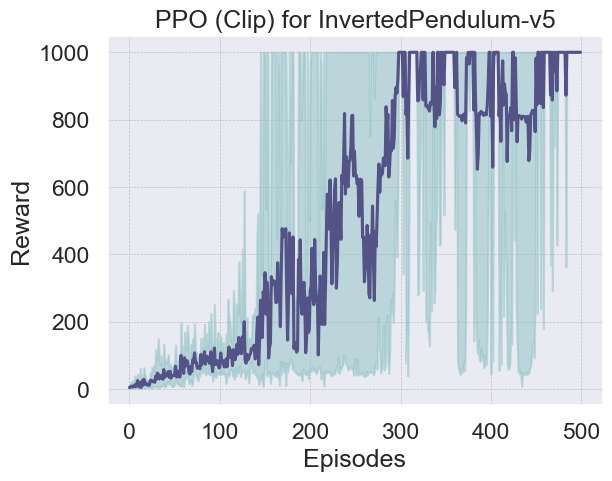

In [46]:
cmap = sns.color_palette("ch:start=.5,rot=-.5", n_colors=15)
df = pd.DataFrame(rewards_over_seeds).melt(var_name="episodes", value_name="reward")

stats = df.groupby("episodes")["reward"].agg(["min", "max", "mean"])
plt.fill_between(stats.index, stats['min'], stats['max'], color=cmap[3], alpha=0.5)
plt.plot(stats.index, stats['mean'], color=cmap[10])

plt.title("PPO (Clip) for InvertedPendulum-v5")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.grid(color="silver", linestyle='--', linewidth=0.5)
plt.show()

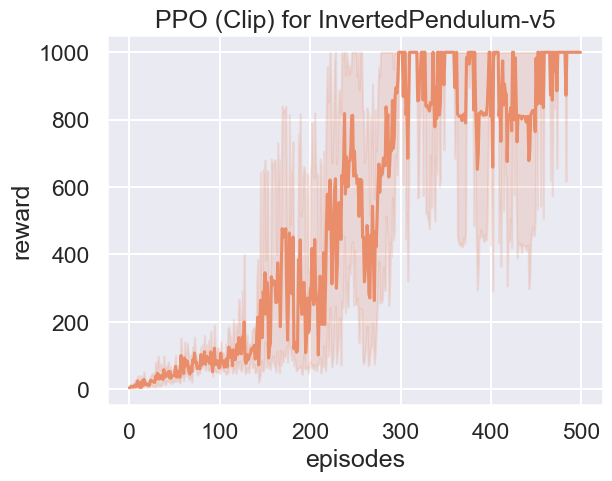

In [52]:
df1 = pd.DataFrame(rewards_over_seeds).melt()
df1.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="flare")
sns.lineplot(x="episodes", y="reward", data=df1).set(title="PPO (Clip) for InvertedPendulum-v5")
plt.show()